In [223]:
from __future__ import absolute_import, division, print_function

import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy as sql

from rmexp import dbutils, config
from rmexp.schema import models
from logzero import logger
import operator
import itertools

In [247]:
sess = dbutils.get_session()

def get_ss(app, trace_ids):
    # get the first frame that state transition happened
    exp_names = ['{}-tr{}'.format(app, idx) for idx in trace_ids]
    ss = []
    for exp_name in exp_names:
        exp_ss = [[int(item.idx), item.val] for item in sess.query(models.SS.val, 
                                               models.SS.name, 
                                               models.SS.index.label('idx')).filter(models.SS.name==exp_name).all()]
        ss.append(exp_ss)
    return ss
lego_trace_ids = [1, 3, 5, 13, 14, 16, 17, 18, 19]
ss = get_exp_ss('lego', lego_trace_ids)
sess.close()

## Effects of Detecting Board on the Client

In [248]:
# find # of frames that do not have boards
for exp_idx, exp_ss in enumerate(ss):
    print('==================lego-tr{}============='.format(exp_idx+1))
    no_board_fss = [fss for fss in exp_ss if ('Failed at stage 1' in fss[1] 
                                              or 'Failed at stage 2' in fss[1] 
                                              or 'Too little black dots, maybe image blurred' in fss[1]
                                              or 'black dots are not inside the board' in fss[1]
                                             )]
    print('# without board {}, # total frames {}'.format(len(no_board_fss), len(exp_ss)))

==================lego-tr1=============
# without board 1849, # total frames 2606
==================lego-tr2=============
# without board 1432, # total frames 2859
==================lego-tr3=============
# without board 754, # total frames 2181
==================lego-tr4=============
# without board 1493, # total frames 2147
==================lego-tr5=============
# without board 1680, # total frames 2237
==================lego-tr6=============
# without board 1742, # total frames 2819
==================lego-tr7=============
# without board 1103, # total frames 2067
==================lego-tr8=============
# without board 1290, # total frames 2366
==================lego-tr9=============
# without board 1497, # total frames 3159


In [250]:
# Use cumulative method to detect stage
class LegoFSM(object):
    """A Lego FSM based on cumulative model."""
    def __init__(self):
        self._state = None
        self._cnt_to_transition = 3
        self._staging_cnt = collections.defaultdict(int)

    def state_change(self, new_state):
        self._state = new_state
        self._staging_cnt.clear()

    def process_ss(self, ss):
        frame_result = ss
        if '[[' in frame_result:
            self._staging_cnt[frame_result] += 1
            if self._staging_cnt[frame_result] == self._cnt_to_transition:
                if self._state != frame_result:
                    self.state_change(frame_result)
                    return True
        return False

def detect_stage(fsm, exp_ss):
    """Detected stages from extracted symbolic states.
    
    cumulative_num: number of cumulative detection of frames for the results to be counted
    """
    exp_stages = []
    for (idx, fss) in enumerate(exp_ss):
        has_state_change = fsm.process_ss(fss[1])
        if has_state_change:
            exp_stages.append(fss)
    return exp_stages

In [251]:
# it takes about 60ms on a 2.3Ghz single core to process if a board is in the frame or not
import numpy as np

def print_stage_info(detected_stages):
    stage_times = []
    print(detected_stages[0])
    for (idx, stage) in enumerate(detected_stages[1:]):
        print('stage {}:'.format(idx+1))
        print(stage)
        stage_time = stage[0] - detected_stages[idx][0]
        print('took {} frames'.format(stage_time))
        stage_times.append(stage_time)
    stage_times = np.array(stage_times)
    print('average stage time: {}, min {}, max {}'.format(np.average(stage_times), 
                                                          np.min(stage_times), 
                                                          np.max(stage_times)))
# find all the detected stage changes, there should be 7 steps in total
dataset_stage_info = []
for exp_idx, exp_ss in enumerate(ss):
    logger.debug('==================lego-tr{}============='.format(lego_trace_ids[exp_idx]))
    detected_stages = detect_stage(LegoFSM(), exp_ss)
    logger.debug('valid? {}. Expected number of states is 7, actual {}'.format(len(detected_stages)==7, len(detected_stages)))
    print(detected_stages)
    dataset_stage_info.append(detected_stages)

[D 190522 21:27:51 <ipython-input-251-c158959e7e8d>:20] ==================lego-tr1=============
[D 190522 21:27:51 <ipython-input-251-c158959e7e8d>:22] valid? True. Expected number of states is 7, actual 7
[D 190522 21:27:51 <ipython-input-251-c158959e7e8d>:20] ==================lego-tr3=============
[D 190522 21:27:51 <ipython-input-251-c158959e7e8d>:22] valid? True. Expected number of states is 7, actual 7
[D 190522 21:27:51 <ipython-input-251-c158959e7e8d>:20] ==================lego-tr5=============
[D 190522 21:27:52 <ipython-input-251-c158959e7e8d>:22] valid? True. Expected number of states is 7, actual 7
[D 190522 21:27:52 <ipython-input-251-c158959e7e8d>:20] ==================lego-tr13=============
[D 190522 21:27:52 <ipython-input-251-c158959e7e8d>:22] valid? False. Expected number of states is 7, actual 5
[D 190522 21:27:52 <ipython-input-251-c158959e7e8d>:20] ==================lego-tr14=============
[D 190522 21:27:52 <ipython-input-251-c158959e7e8d>:22] valid? False. Expecte

[[289, '[[2 2 2 2]]'], [511, '[[0 0 1 0]\n [2 2 2 2]]'], [815, '[[0 0 1 6]\n [2 2 2 2]]'], [1169, '[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]'], [1666, '[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]'], [2103, '[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]'], [2424, '[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]']]
[[319, '[[2 2 2 2]]'], [706, '[[0 0 1 0]\n [2 2 2 2]]'], [1115, '[[0 0 1 6]\n [2 2 2 2]]'], [1496, '[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]'], [1873, '[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]'], [2322, '[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]'], [2805, '[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]']]
[[493, '[[2 2 2 2]]'], [702, '[[0 0 1 0]\n [2 2 2 2]]'], [1002, '[[0 0 1 6]\n [2 2 2 2]]'], [1230, '[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]'], [1430, '[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]'], [1821, '[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]'], [2034, '[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]']]
[[217, '[[2 2 2 2]]'], [444, '[[0 0 1 0]\n [2 2 2 2]]'], [738, '[[0 0 1 6]\n [2 2 2 2]]'], [1052, '[[0 0 1 1]\n [0 0 1 6]\n [

In [57]:
# get dataset stage information
# avg stage length 14.13, min 6.6, max 27.2
dataset_stage_frame_idx = np.array(dataset_stage_info)[:, :, 0].astype('int')
logger.debug(dataset_stage_frame_idx)
dataset_stage_length = (dataset_stage_frame_idx[:, 1:] - dataset_stage_frame_idx[:, :-1])/30.0
logger.info("stage length (# s) \n{}".format(dataset_stage_length))
logger.info("avg stage length by user \n{}".format(np.mean(dataset_stage_length, axis=1)))
logger.info("avg stage length by stage \n{}".format(np.mean(dataset_stage_length, axis=0)))
logger.info("avg stage length {:.2f}, min {}, max {}".format(np.mean(dataset_stage_length), 
                                                         np.min(dataset_stage_length), 
                                                         np.max(dataset_stage_length)))
def plot_stage_duration(data):
    data = data.flatten()
    plt.figure()
    plt.hist(data);
    plt.ylabel('Count');
    plt.xlabel('stage duration (s)');
    plt.title('Lego Stage Duration')

plot_stage_duration(dataset_stage_length)

IndexError: too many indices for array

In [ ]:
%matplotlib notebook

# fit a gaussian model using MLE for stage duration
# the mean is just sample mean, and sigma is just sample std
from scipy.stats import norm

def fit_gaussian(data):
    data = data.flatten()
    return np.mean(data), np.std(data)

stage_duration_gaussian_model = fit_gaussian(dataset_stage_length)
print('fitted Gaussian Model has mu {} and sigma {}'.format(*stage_duration_gaussian_model))
plot_stage_duration(dataset_stage_length)
plt.figure()
x = np.linspace(0, np.max(dataset_stage_length)*1.2, 100)
plt.plot(x, norm.pdf(x, *stage_duration_gaussian_model));

## Dynamic Sampling Rate

k consecutive frames, S is the sampling period, p is the processing delay for a frame (use average as an estimate), b is the bound:

(k+1) * S + p <= b

1000/S <= max_sampling_frequency

1000/S <= min(maximum processing rate, network transmission rate)

So for lego (370 is the average full processing delay from trace 1 to 5, running on 2 cloudlet cores)

(5 + 1) * S + 370 <= 2700

1000/S <= 30
1000/S <= min(maximum processing rate, network transmission rate)

Then use the CDF of the curve as the dynamic sampling rate ranged from 2.58 Hz to 30 Hz

In [ ]:
from scipy.stats import norm

# implement dynamic sample rate
def get_average_full_proc_delay():
    ds_full_proc_delay = []
    for exp_name in exp_names:
        full_proc_idx = [int(item.idx) for item in sess.query(models.SS.val, models.SS.name, 
                                           models.SS.index.label('idx')).filter(
                                            models.SS.name==exp_name).filter(
                                            models.SS.val.like("%[[%")
                                            ).all()]
        proc_delay = [(int(item.val), int(item.idx)) for item in sess.query(models.LegoLatency.val, models.LegoLatency.name, 
                                           models.LegoLatency.index.label('idx')).filter(
                                            models.LegoLatency.name==exp_name).all()]
        full_proc_delay = map(lambda x: int(x[0]), 
                              (filter(lambda (val, idx): idx in full_proc_idx, proc_delay)))
        ds_full_proc_delay.append(full_proc_delay)
    ds_full_proc_delay = list(itertools.chain.from_iterable(ds_full_proc_delay))
    return np.mean(np.array(ds_full_proc_delay))

proc_delays = {
    'lego': 457 # see the bottom of utility-function notebook. this is the 90th percentile of processing delay
}

# sr_min is 370
# avg_full_proc_delay = round(get_average_full_proc_delay())
proc_delay = proc_delays['lego']
sr_min = 1000.0 / ((2700 - proc_delay) / 2.0)
print('sr_min is {}'.format(sr_min))
sr_max = 30.0
recover_factor = 3
dynamic_sample_rate = lambda x: sr_min + float(sr_max - sr_min) * min(recover_factor * norm.cdf(
    x, *stage_duration_gaussian_model), 1.0)

def plot_lego_sample_rate():
    x=np.linspace(0, 30, 100)
    y = np.vectorize(dynamic_sample_rate, otypes=[np.float])(x)
    plt.figure(figsize=(2,3))
    plt.plot(x, y, 'black')
#     plt.title('Adaptive Sampling Frequency', fontsize=20)
    plt.xlabel('Time in Passive Phase (s)', fontsize=16)
    plt.ylabel('Sampling Rate (Hz)', fontsize=18)

plot_lego_sample_rate()

In [ ]:
# Simulate Dynamic sampling rate!
import collections

# stop slowing down when x is larger than 15
def simulate_dynamic_sample_rate(sample_rate_func, max_mute_t):
    """Simulate dynamic sampling rate.
    sample_rate_func: function of dynamic sample rate. Input should the the time after a given instruction.
    max_mute_t: maximum time this sample_rate_func is in place
    
    Return simulated trace, stage_frame_idx
    """
    import copy
    sr = 30.0
    
    def get_mute_fr(sample_rate_func, fss, mute_st):
        dysr = sample_rate_func((fss[0] - mute_st) / float(sr))
        mute_fr = int(1.0 / dysr * sr)
        if dysr >= 30.0 - 10e-4:
            mute_fr = 0
        return mute_fr
    fsm = LegoFSM()
        
    max_mute_fr = int(max_mute_t * sr)
    dy_ss = []
    dy_stage_frame_idx = []
    for vid, exp_ss in enumerate(ss):
        dyexp_ss = copy.deepcopy(exp_ss)
        stage_frame_idx = []
        mute_st = None
        mute_fr = 0
        for fss in dyexp_ss:
            # check mute
            if mute_fr > 0:
                fss[1] = None
                mute_fr -= 1
                continue

            if mute_st is not None and (fss[0] - mute_st) / sr > max_mute_t:
                mute_st = None
                mute_fr = 0

            transition = fsm.process_ss(fss[1])
            if transition:
                mute_st = fss[0]
                stage_frame_idx.append(mute_st)

            if mute_st is not None:
                mute_fr = get_mute_fr(sample_rate_func, fss, mute_st)
            
        dy_ss.append(dyexp_ss)
        dy_stage_frame_idx.append(stage_frame_idx)
    return dy_ss, dy_stage_frame_idx

[[ 288  518  816 1168 1656 2102 2426]
 [ 236  683 1065 1393 1910 2287 2763]
 [ 318  705 1114 1495 1872 2321 2804]
 [ 252  588 1203 1595 1989 2496 2890]
 [ 492  711 1009 1234 1440 1820 2045]]
[[ 291  513  817 1177 1668 2105 2426]
 [ 239  686 1073 1395 1918 2300 2766]
 [ 321  708 1118 1498 1875 2324 2821]
 [ 260  591 1206 1598 1992 2500 2893]
 [ 495  704 1004 1234 1432 1823 2036]]
Difference in frames: 
[[ -3   5  -1  -9 -12  -3   0]
 [ -3  -3  -8  -2  -8 -13  -3]
 [ -3  -3  -4  -3  -3  -3 -17]
 [ -8  -3  -3  -3  -3  -4  -3]
 [ -3   7   5   0   8  -3   9]]
average: -2.94285714286, std: 5.3609319933
supressed # samples: 1764.0, percentage: 0.676899462778
supressed # samples: 1883.0, percentage: 0.631455399061
supressed # samples: 1734.0, percentage: 0.606505771249
supressed # samples: 1889.0, percentage: 0.607200257152
supressed # samples: 1500.0, percentage: 0.687757909216


<IPython.core.display.Javascript object>


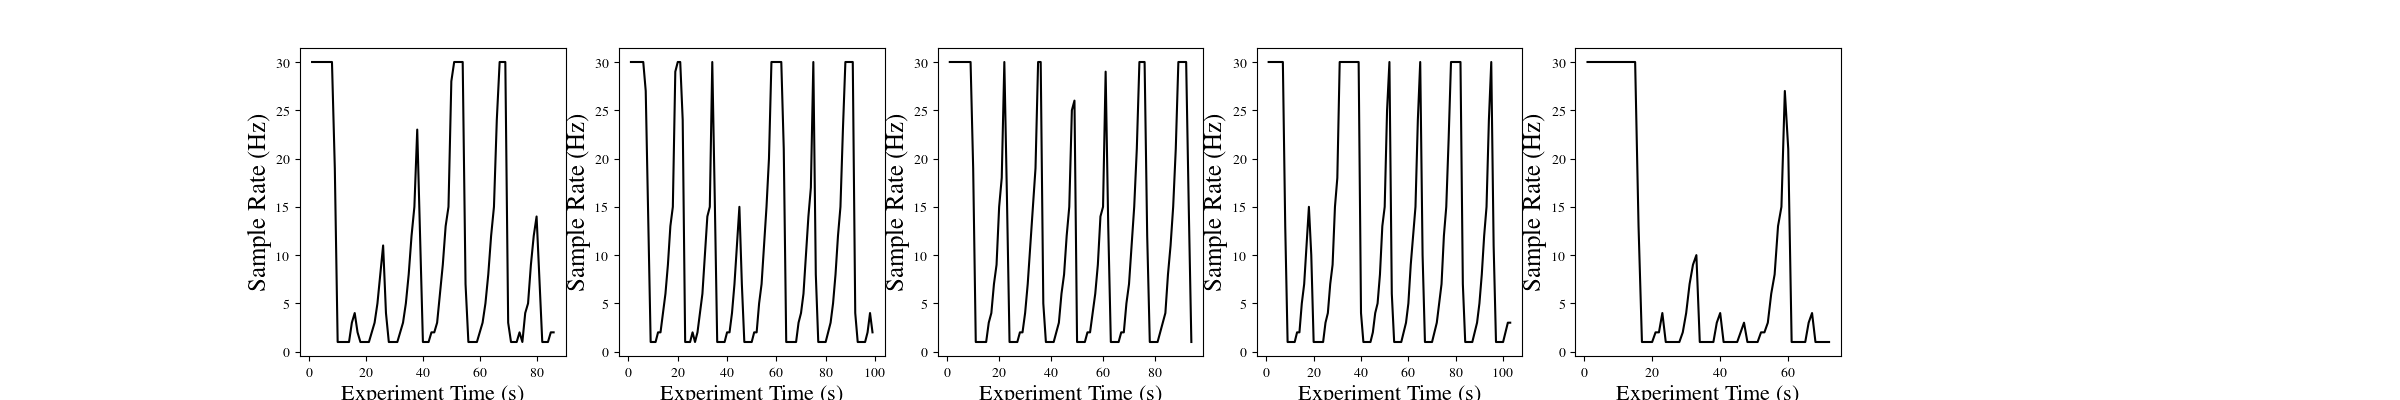

<IPython.core.display.Javascript object>


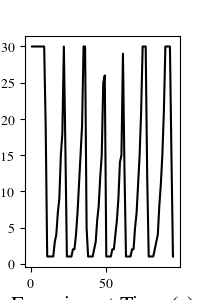

In [58]:
# show and plot dynamic sampling rate
dy_ss, dy_stage_frame_idx = simulate_dynamic_sample_rate(dynamic_sample_rate, np.max(dataset_stage_length))
dy_stage_frame_idx = np.asarray(dy_stage_frame_idx)
print(dy_stage_frame_idx)
print(dataset_stage_frame_idx)
dy_stage_frame_diff = dy_stage_frame_idx - dataset_stage_frame_idx
print('Difference in frames: ')
print(dy_stage_frame_diff)
print('average: {}, std: {}'.format(np.mean(dy_stage_frame_diff), np.std(dy_stage_frame_diff)))

for idx, dy_exp_ss in enumerate(dy_ss):
    num_suppressed = float(len([item[0] for item in dy_exp_ss if item[1] is None]))
    num_total = float(len(ss[idx]))
    print('supressed # samples: {}, percentage: {}'.format(num_suppressed, num_suppressed/num_total))

def plot_dy_sampling_freq(dy_exp_ss):
    import collections
    sampled_idx = [item[0] for item in dy_exp_ss if item[1] is not None]
    sampled_idx = map(lambda x: int(x/30.0), sampled_idx)
    freq_counter = collections.Counter(sampled_idx)
    sorted_freqs = sorted(freq_counter.items(), key=lambda pair: pair[0])
    x, y = zip(*sorted_freqs)
    plt.plot(x[1:], y[1:], 'black')
    plt.xlabel('Experiment Time (s)',  fontsize=16)
    plt.ylabel('Sample Rate (Hz)', fontsize=18)


# plot a single trace
plt.figure(figsize=(24, 4))
for (h_idx, dy_exp_ss) in enumerate(dy_ss):
    plt.subplot(1, len(dy_ss)+1, h_idx+1)
    plot_dy_sampling_freq(dy_exp_ss)

plt.figure(figsize=(2, 3))
dy_exp_ss = dy_ss[2]
plot_dy_sampling_freq(dy_exp_ss)
plt.savefig('fig-lego-example-sr.pdf', bbox_inches='tight')

### Baseline to use to compare with dynamic sampling rate

In [51]:
# some baseline frequency sampling savings and results
import copy
def print_stage_diff(stage_info, ref_stage_frame_idx):
    dataset_stage_frame_idx = np.array(stage_info)[:, :, 0].astype('int')
    stage_frame_diff = dataset_stage_frame_idx - ref_stage_frame_idx
    # logger.debug('Difference in frames: {}'.format(stage_frame_diff))
    logger.debug('average: {}, std: {}'.format(np.mean(stage_frame_diff), np.std(stage_frame_diff)))

bsr = 30.0
srs = [15.0, 10.0]
for sr in srs:
    assert(bsr % sr == 0)
    period = int(bsr / sr)
    logger.info('sampling rate: {}, period: {}'.format(sr, period))
    sr_ss = copy.deepcopy([exp_ss[0::period] for exp_ss in ss])
    sr_ds_stage_info = []
    for sr_exp_ss in sr_ss:
        sr_ds_stage_info.append(detect_stage(sr_exp_ss, 5))
    print_stage_diff(sr_ds_stage_info, dataset_stage_frame_idx)


[I 190522 15:28:37 <ipython-input-51-a052d5d4242c>:14] sampling rate: 15.0, period: 2


IndexError: too many indices for array

# Ikea Duty Cycle

In [252]:
import ast
import re 
import collections

class IkeaFSM(object):
    """A Lego FSM based on cumulative model."""
    def __init__(self, (im_h, im_w)):
        self._states = ["start", "nothing", "base", "pipe", "shade", "buckle", 
                       "blackcircle", "shadebase", "bulb", "bulbtop"]
        self.current_state = "nothing"
        self._objects = ["base", "pipe", "shade", "shadetop", "buckle", "blackcircle", "lamp", "bulb", "bulbtop"]
        self._staging_cnt = collections.defaultdict(int)
        self._im_h = im_h
        self._im_w = im_w
        self.one_buckle_frame_counter = 0
        self.two_buckle_frame_counter = 0
        
    def state_change(self, new_state):
        self._state = new_state
        self._staging_cnt.clear()

    def _get_objects(self, ss):
        objs = []
        # tf's output format ymin, xmin, ymax, xmax
        # zhuo's objects format: [x1, y1, x2, y2, confidence, cls_idx]
        if 'Detected Objects: ' in ss:
            obj_dets = ss.replace('Detected Objects: ', '').split(', ')
            for obj_det in obj_dets:
                obj_name = obj_det.split(' ')[0]
                loc_str = obj_det.replace(obj_name, '')
                # try to match floating point number first 
                # and then match both scientification notaion
                loc_matches = re.findall(
                        r'(\d+\.*\d*)', loc_str)
                loc = map(float, loc_matches)
                if len(loc) != 4:
                    loc_matches = re.findall(r'(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)', loc_str)
                    loc = map(float, loc_matches)
                assert len(loc) == 4, loc_str
                assert obj_name in self._objects
                objs.append([loc[1] * self._im_w, 
                             loc[0] * self._im_h,
                             loc[3] * self._im_w, 
                             loc[2] * self._im_h,
                             1.0, self._objects.index(obj_name)])
        return np.array(objs)
        
    def process_ss(self, ss):
        objects = self._get_objects(ss)
        if len(objects.shape) < 2:
            return False
        
        object_counts = []
        for i in xrange(len(self._objects)):
            object_counts.append(sum(objects[:, -1] == i))
            
        prev_state = self.current_state
        if self.current_state == "nothing":
            if object_counts[0] > 0 and object_counts[1] > 0:
                if self._check_pipe(objects):
                    self.current_state = "pipe"
            elif object_counts[0] > 0:
                self.current_state = "base"
        elif self.current_state == "base":
            if object_counts[0] > 0 and object_counts[1] > 0:
                if self._check_pipe(objects):
                    self.current_state = "pipe"
        elif self.current_state == "pipe":
            if object_counts[2] > 0:
                self.current_state = "shade"
        elif self.current_state == "shade":
            if object_counts[3] > 0 and object_counts[4] > 0:
                n_buckles = self._check_buckle(objects)
                if n_buckles == 2:
                    self.one_buckle_frame_counter = 0
                    self.two_buckle_frame_counter += 1
                    if self.two_buckle_frame_counter > 3:
                        self.current_state = "buckle"
        elif self.current_state == "buckle":
            if object_counts[5] > 0:
                self.current_state = "blackcircle"
        elif self.current_state == "blackcircle":
            if object_counts[6] > 0:
                self.current_state = "shadebase"
        elif self.current_state == "shadebase":
            if object_counts[7] > 0:
                self.current_state = "bulb"
        elif self.current_state == "bulb":
            if object_counts[3] > 0 and object_counts[8] > 0:
                if self._check_bulbtop(objects):
                    self.current_state = "bulbtop"

        if prev_state != self.current_state:
            return True
        else:
            return False

    def _check_pipe(self, objects):
        bases = []
        pipes = []
        for i in xrange(objects.shape[0]):
            if int(objects[i, -1] + 0.1) == 0:
                bases.append(objects[i, :])
            if int(objects[i, -1] + 0.1) == 1:
                pipes.append(objects[i, :])

        for base in bases:
            base_center = ((base[0] + base[2]) / 2, (base[1] + base[3]) / 2)
            base_width = base[2] - base[0]
            base_height = base[3] - base[1]
            for pipe in pipes:
                pipe_center = ((pipe[0] + pipe[2]) / 2, (pipe[1] + pipe[3]) / 2)
                pipe_height = pipe[3] - pipe[1]
                if pipe_center[1] > base_center[1]:
                    continue
                if pipe_center[0] < base_center[0] - base_width * 0.25 or pipe_center[0] > base_center[0] + base_width * 0.25:
                    continue
                if pipe_height / base_height < 1.5:
                    continue
                return True
        return False

    def _check_buckle(self, objects):
        shadetops = []
        buckles = []
        for i in xrange(objects.shape[0]):
            if int(objects[i, -1] + 0.1) == 3:
                shadetops.append(objects[i, :])
            if int(objects[i, -1] + 0.1) == 4:
                buckles.append(objects[i, :])

        for shadetop in shadetops:
            shadetop_center = ((shadetop[0] + shadetop[2]) / 2, (shadetop[1] + shadetop[3]) / 2)
            shadetop_width = shadetop[2] - shadetop[0]
            shadetop_height = shadetop[3] - shadetop[1]

            left_buckle = False
            right_buckle = False
            for buckle in buckles:
                buckle_center = ((buckle[0] + buckle[2]) / 2, (buckle[1] + buckle[3]) / 2)
                if buckle_center[1] < shadetop[1] or buckle_center[1] > shadetop[3]:
                    continue
                if buckle_center[0] < shadetop[0] or buckle_center[0] > shadetop[2]:
                    continue
                if buckle_center[0] < shadetop_center[0]:
                    left_buckle = True
                else:
                    right_buckle = True
            if left_buckle and right_buckle:
                break

        return int(left_buckle) + int(right_buckle)

    def _check_bulbtop(self, objects):
        shadetops = []
        bulbtops = []
        for i in xrange(objects.shape[0]):
            if int(objects[i, -1] + 0.1) == 3:
                shadetops.append(objects[i, :])
            if int(objects[i, -1] + 0.1) == 8:
                bulbtops.append(objects[i, :])

        for shadetop in shadetops:
            shadetop_center = ((shadetop[0] + shadetop[2]) / 2, (shadetop[1] + shadetop[3]) / 2)
            shadetop_width = shadetop[2] - shadetop[0]
            shadetop_height = shadetop[3] - shadetop[1]

            for bulbtop in bulbtops:
                bulbtop_center = ((bulbtop[0] + bulbtop[2]) / 2, (bulbtop[1] + bulbtop[3]) / 2)
                if bulbtop_center[1] < shadetop[1] or bulbtop_center[1] > shadetop[3]:
                    continue
                if bulbtop_center[0] < shadetop[0] or bulbtop_center[0] > shadetop[2]:
                    continue
                if bulbtop_center[0] < shadetop_center[0] - shadetop_width * 0.25 or bulbtop_center[0] > shadetop_center[0] + shadetop_width * 0.25:
                    continue
                if bulbtop_center[1] < shadetop_center[1] - shadetop_height * 0.25 or bulbtop_center[1] > shadetop_center[1] + shadetop_height * 0.25:
                    continue
                return True
        return False

In [253]:
ikea_resolution = collections.defaultdict(lambda: (168, 300))
ikea_resolution[1] = (200, 300)
ss = get_ss('ikea', [1, 2, 3, 4, 5])
for idx, exp_ss in enumerate(ss):
    fsm = IkeaFSM(ikea_resolution[idx])
    detected_stages = detect_stage(fsm, exp_ss)
    logger.debug('instruction number: {}'.format(len(detected_stages)))

[D 190522 22:50:11 <ipython-input-253-5f922da152e1>:7] instruction number: 8
[D 190522 22:50:11 <ipython-input-253-5f922da152e1>:7] instruction number: 1
[D 190522 22:50:11 <ipython-input-253-5f922da152e1>:7] instruction number: 3
[D 190522 22:50:11 <ipython-input-253-5f922da152e1>:7] instruction number: 8
[D 190522 22:50:12 <ipython-input-253-5f922da152e1>:7] instruction number: 1


## Ping-Pong Duty Cycle

Uses "Cannot find Table" as a method to suppress 1s

In [7]:
sess = dbutils.get_session()

# get the first frame that state transition happened
exp_names = ['pingpong-tr{}'.format(idx) for idx in range(1, 6)]
ss = []
for exp_name in exp_names:
    exp_ss = [[int(item.idx), item.val] for item in sess.query(models.SS.val, 
                                           models.SS.name, 
                                           models.SS.index.label('idx')).filter(models.SS.name==exp_name).all()]
    ss.append(exp_ss)
sess.close()

state_no_table_msgs = [
    'Cannot find table',
    'Detected table too small',
    'Table top line too short',
    'Table top line tilted too much',
    "Table doesn't occupy bottom part of image",
    'Angle between two side edge not right',
    'Valid area too small after rotation'
]

def has_table(state):
    for msg in state_no_table_msgs:
        if msg in state:
            return False
    return True

In [37]:
def interval_extract(input_list): 
    """Extract continuous intervals out of a list of items"""
    length = len(input_list) 
    i = 0
    while (i< length): 
        low = input_list[i] 
        while i <length-1 and input_list[i]+1 == input_list[i + 1]: 
            i += 1
        high = input_list[i] 
        if (high - low >= 1): 
            yield [low, high] 
        elif (high - low == 1): 
            yield [low, ] 
            yield [high, ] 
        else: 
            yield [low, ] 
        i += 1

ds_long_no_table = [[], []]
long_no_table_thresh = 60
for (idx, exp_ss) in enumerate(ss):
    logger.info('========== pingpong-trace{} =============='.format(idx+1))
    no_table_idx = [item[0] for item in exp_ss if not has_table(item[1])]
    no_table_intervals = list(interval_extract(no_table_idx))
    long_no_table_intervals = zip(*[[item[0], item[1]-item[0]] for 
                               item in no_table_intervals if len(item) > 1 and item[1] - item[0] > long_no_table_thresh])
    logger.info(long_no_table_intervals)
    ds_long_no_table[0].append(long_no_table_intervals[0])
    ds_long_no_table[1].append(long_no_table_intervals[1])

[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace1 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(56, 200), (82, 125)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace2 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(108, 961, 1342, 2398), (67, 91, 135, 170)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace3 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(344, 813, 1176), (112, 70, 61)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace4 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(771,), (88,)]
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:22] ========== pingpong-trace5 ==============
[I 190428 23:56:20 <ipython-input-37-4843cfafef49>:27] [(90, 1543), (111, 79)]


<IPython.core.display.Javascript object>


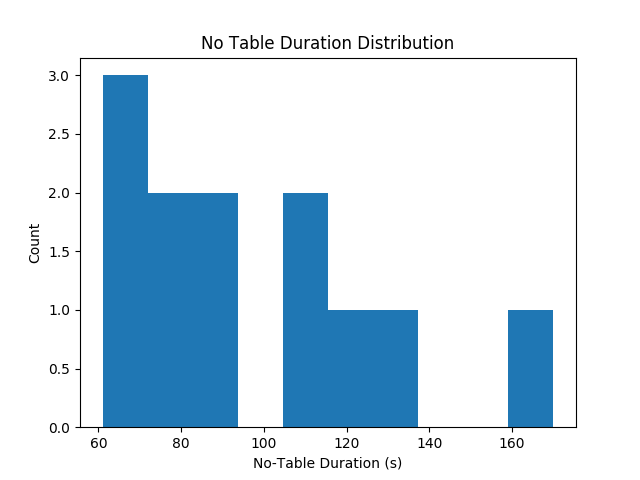

In [38]:
%matplotlib notebook
def plot_no_table_duration(data):
    data = data.flatten()
    plt.figure()
    plt.hist(data);
    plt.ylabel('Count');
    plt.xlabel('No-Table Duration (s)');
    plt.title('No Table Duration Distribution')

plot_no_table_duration(np.array([item for sublist in ds_long_no_table[1] for item in sublist]))

In [ ]:
# plot key frame and then use supression as a way
for (idx, exp_ss) in enumerate(ss):
    logger.info('========== pingpong-trace{} =============='.format(idx+1))